# Perceptual Distance vs Feature Distance Modeling

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

from ast import literal_eval
from itertools import combinations
from sklearn import linear_model, model_selection, preprocessing, utils
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from scipy.stats import spearmanr

In [2]:
stimuli_features = pd.read_csv('stimuli_features.csv', index_col='stimulus')
stimuli_features.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
stimulus,,,,,,,,,,,,,,,,,,,,,
70,0.309023,0.313771,0.0,0.0,0.372372,0.407554,0.407554,0.372372,1.000000,0.459400,...,0.451076,0.243894,0.246024,0.922029,0.120735,0.333333,0.310345,0.318841,0.000000,0.328767
119,0.083732,0.111151,1.0,0.0,0.066559,0.076912,0.076912,0.066559,0.270594,0.152808,...,0.091680,0.066679,0.107739,0.425863,0.036745,0.066667,0.068966,0.057971,0.355556,0.123288
6,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.321536,0.000000,...,0.000000,0.000000,0.000000,0.596209,0.000000,0.000000,0.000000,0.000000,0.266667,0.000000
56,0.104851,0.138843,1.0,0.0,0.055429,0.215424,0.215424,0.055429,0.202443,0.165708,...,0.243986,0.105099,0.107739,0.425863,0.028871,0.133333,0.103448,0.101449,0.572840,0.054795
118,0.264151,0.347411,1.0,0.0,0.239191,0.274966,0.274966,0.239191,0.388381,0.402407,...,0.323506,0.208293,0.323216,0.238483,0.139108,0.266667,0.241379,0.217391,0.750617,0.328767


In [5]:
probabilities = pd.read_csv('stimuli_probabilities.csv')
probabilities['stimuli'] = probabilities['stimuli'].apply(literal_eval)
probabilities.index = pd.MultiIndex.from_tuples(probabilities['stimuli'], names=['stimulus_1', 'stimulus_2'])
probabilities = probabilities.drop('stimuli', axis=1).unstack()
probabilities.columns = probabilities.columns.droplevel()
probabilities.head()

In [29]:
def perceptual_distance(stimuli, probabilities):
    p_nogo_ab = 1 - probabilities.loc[stimuli]
    p_nogo_aa = 1 - probabilities.loc[(stimuli[0], stimuli[0])]
    p_nogo_bb = 1 - probabilities.loc[(stimuli[1], stimuli[1])]
    distance = 1 - ((1 - p_nogo_ab)/(math.sqrt((1 - p_nogo_aa) * (1 - p_nogo_bb))))
    return distance

def f(weights, features, probabilities):
    distance_matrix = pdist(features, 'euclidean', w=weights)
    feature_distance = pd.DataFrame(squareform(distance_matrix))
    feature_distance.index = features.index
    feature_distance.columns = features.index
    
    data = pd.DataFrame(columns=['stimuli', 'feature_distance', 'probability'])
    for stim_pairs in combinations(feature_distance.index, 2):
        stim_pairs = tuple(sorted(stim_pairs))
        if not np.isnan(probabilities.loc[stim_pairs]):
            data.loc[len(data.index)] = [stim_pairs, feature_distance.loc[stim_pairs], probabilities.loc[stim_pairs]]
    data['perceptual_distance'] = data[['stimuli']].apply(lambda x: perceptual_distance(x['stimuli'], probabilities), axis=1)
    
    r = spearmanr(data['feature_distance'], data['perceptual_distance'])
    return -(r.correlation)

n_features = stimuli_features.shape[1]
weights_guess = np.ones(n_features)
result = minimize(f, weights_guess, args=(stimuli_features, probabilities), bounds=[(0, 1)]*n_features)
best_weights = result.x

In [30]:
result

      fun: -0.3555002802910996
 hess_inv: <1486x1486 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3133.25794358,    49.71272271,  -986.69639099, ...,
       -4528.38982719, -1931.85360403, -3083.95317547])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 31227
      nit: 0
     njev: 21
   status: 1
  success: False
        x: array([1., 1., 1., ..., 1., 1., 1.])

In [34]:
np.unique(best_weights)

array([1.])

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data['feature_distance'], data['perceptual_distance'], test_size=0.25, random_state=0)

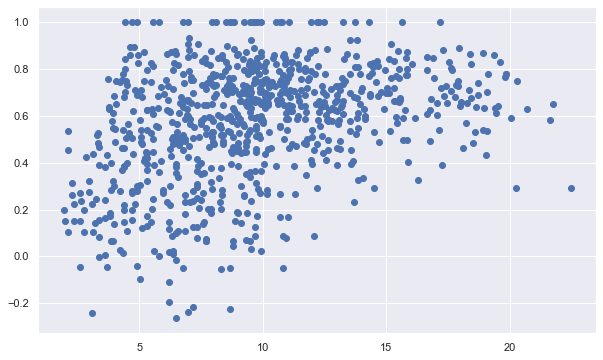

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(X_train, y_train)
plt.show()

In [13]:
poly_model = make_pipeline(preprocessing.PolynomialFeatures(3, include_bias=False),
                           linear_model.LinearRegression(fit_intercept=False))
poly_model.fit(data['feature_distance'].values.reshape(-1, 1), data['perceptual_distance']);

In [14]:
xfit = np.linspace(0, 25, 1000)
yfit = poly_model.predict(xfit.reshape(-1, 1))

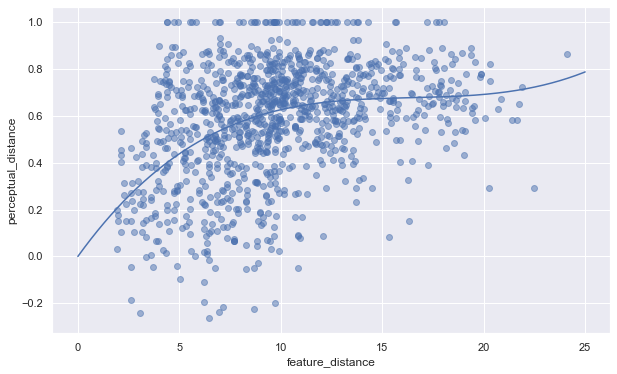

In [15]:
plt.figure(figsize=(10, 6))
plt.axes(xlabel='feature_distance', ylabel='perceptual_distance')
plt.scatter(data['feature_distance'], data['perceptual_distance'], alpha=0.5)
plt.plot(xfit, yfit)
plt.show();